# returns

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit
import empyrical

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [3]:
# Disable caching for performance testing
vbt.settings.caching['enabled'] = False
vbt.settings.returns['year_freq'] = '252 days' # same as empyrical

In [4]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5], 
    'b': [5, 4, 3, 2, 1],
    'c': [1, 2, 3, 2, 1]
}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0


In [5]:
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [6]:
returns = ts.vbt.pct_change()
print(returns)

big_returns = big_ts.vbt.pct_change()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000


In [9]:
np.random.seed(42)
benchmark_rets = returns['a'] * np.random.uniform(0.8, 1.2, returns.shape[0])
big_benchmark_rets = big_returns[0] * np.random.uniform(0.8, 1.2, big_returns.shape[0])

In [8]:
# Test year frequency
print(returns.vbt.returns.year_freq)
print(returns['a'].vbt.returns.year_freq)
print(returns.vbt.returns(year_freq='252 days').year_freq)
print(returns['a'].vbt.returns(year_freq='252 days').year_freq)

252 days 00:00:00
252 days 00:00:00
252 days 00:00:00
252 days 00:00:00


In [9]:
print(returns.vbt.returns.ann_factor) # default
print(returns.vbt.returns(year_freq='252 days').ann_factor)

252.0
252.0


In [10]:
print(returns['a'].vbt.returns.daily()) # already daily, do nothing
print(returns.vbt.returns.daily())

%timeit big_returns.vbt.returns.daily()

2018-01-01         NaN
2018-01-02    1.000000
2018-01-03    0.500000
2018-01-04    0.333333
2018-01-05    0.250000
Freq: D, Name: a, dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000
10.7 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
print(returns['a'].vbt.returns.annual())
print(returns.vbt.returns.annual())

%timeit big_returns.vbt.returns.annual()

2018-01-01    4.0
Freq: 252D, Name: a, dtype: float64
              a    b             c
2018-01-01  4.0 -0.8  2.980232e-08
8.71 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(empyrical.cum_returns(returns['a']))
%timeit empyrical.cum_returns(big_returns[0])

print(returns['a'].vbt.returns.cumulative())
%timeit big_returns[0].vbt.returns.cumulative()

print(returns.vbt.returns.cumulative())
print(returns.vbt.returns.cumulative(start_value=1))
%timeit big_returns.vbt.returns.cumulative()

2018-01-01    0.0
2018-01-02    1.0
2018-01-03    2.0
2018-01-04    3.0
2018-01-05    4.0
Freq: D, dtype: float64
1 ms ± 20 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2018-01-01    0.0
2018-01-02    1.0
2018-01-03    2.0
2018-01-04    3.0
2018-01-05    4.0
Freq: D, Name: a, dtype: float64
65.9 µs ± 808 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
              a    b             c
2018-01-01  0.0  0.0  0.000000e+00
2018-01-02  1.0 -0.2  1.000000e+00
2018-01-03  2.0 -0.4  2.000000e+00
2018-01-04  3.0 -0.6  1.000000e+00
2018-01-05  4.0 -0.8  2.980232e-08
              a    b    c
2018-01-01  1.0  1.0  1.0
2018-01-02  2.0  0.8  2.0
2018-01-03  3.0  0.6  3.0
2018-01-04  4.0  0.4  2.0
2018-01-05  5.0  0.2  1.0
3.84 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
print(empyrical.cum_returns_final(returns['a']))
%timeit empyrical.cum_returns_final(big_returns[0])

print(returns['a'].vbt.returns.total())
%timeit big_returns[0].vbt.returns.total()

print(returns.vbt.returns.total())
%timeit big_returns.vbt.returns.total()

print(returns.vbt.returns.rolling_total(3, minp=1))
%timeit big_returns.vbt.returns.rolling_total(3, minp=1)

4.000000149011612
87.6 µs ± 869 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.000000149011612
28.4 µs ± 264 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    4.000000e+00
b   -8.000000e-01
c    2.980232e-08
Name: total_return, dtype: float64
5.93 ms ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a     b    c
2018-01-01  NaN   NaN  NaN
2018-01-02  1.0 -0.20  1.0
2018-01-03  2.0 -0.40  2.0
2018-01-04  3.0 -0.60  1.0
2018-01-05  1.5 -0.75 -0.5
117 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(empyrical.annual_return(returns['a']))
%timeit empyrical.annual_return(big_returns[0])

print(returns['a'].vbt.returns.annualized())
%timeit big_returns[0].vbt.returns.annualized()

print(returns.vbt.returns.annualized())
%timeit big_returns.vbt.returns.annualized()

print(returns.vbt.returns.rolling_annualized(3, minp=1))
%timeit big_returns.vbt.returns.rolling_annualized(3, minp=1)

1.690786886567203e+35
93.5 µs ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.6907868865671834e+35
49.4 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    1.690787e+35
b   -1.000000e+00
c    1.502038e-06
Name: annualized_return, dtype: float64
6.01 ms ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                       a    b             c
2018-01-01           NaN  NaN           NaN
2018-01-02  8.507059e+37 -1.0  8.507059e+37
2018-01-03  1.197252e+40 -1.0  1.197252e+40
2018-01-04  3.741454e+50 -1.0  1.934286e+25
2018-01-05  2.672771e+33 -1.0 -1.000000e+00
148 ms ± 602 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
print(empyrical.annual_volatility(returns['a'], alpha=3.))
%timeit empyrical.annual_volatility(big_returns[0], alpha=3.)

print(returns['a'].vbt.returns.annualized_volatility(levy_alpha=3.))
%timeit big_returns[0].vbt.returns.annualized_volatility(levy_alpha=3.)

print(returns.vbt.returns.annualized_volatility(levy_alpha=3.))
%timeit big_returns.vbt.returns.annualized_volatility(levy_alpha=3.)

print(returns.vbt.returns.rolling_annualized_volatility(3, minp=1, levy_alpha=3.))
%timeit big_returns.vbt.returns.rolling_annualized_volatility(3, minp=1, levy_alpha=3.)

2.121838249438074
17.2 µs ± 314 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.121838249438074
60.7 µs ± 382 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    2.121838
b    0.830587
c    4.466341
Name: annualized_volatility, dtype: float64
5.85 ms ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  2.233170  0.223317  2.233170
2018-01-04  2.191425  0.425454  4.254544
2018-01-05  0.804033  0.804033  3.384043
251 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
print(empyrical.calmar_ratio(returns['b']))
%timeit empyrical.calmar_ratio(big_returns[0])

print(returns['b'].vbt.returns.calmar_ratio())
%timeit big_returns[0].vbt.returns.calmar_ratio()

print(returns.vbt.returns.calmar_ratio())
%timeit big_returns.vbt.returns.calmar_ratio()

print(returns.vbt.returns.rolling_calmar_ratio(3, minp=1))
%timeit big_returns.vbt.returns.rolling_calmar_ratio(3, minp=1)

-1.2500000139698388
145 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-1.2500000139698388
58 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a         NaN
b   -1.250000
c    0.000002
Name: calmar_ratio, dtype: float64
13.8 ms ± 34.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
             a    b             c
2018-01-01 NaN  NaN           NaN
2018-01-02 NaN -5.0           NaN
2018-01-03 NaN -2.5           NaN
2018-01-04 NaN -2.0  5.802859e+25
2018-01-05 NaN -1.5 -1.500000e+00
622 ms ± 3.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(empyrical.omega_ratio(returns['c'], risk_free=0.01, required_return=0.1))
%timeit empyrical.omega_ratio(big_returns[0], risk_free=0.01, required_return=0.1)

print(returns['c'].vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1))
%timeit big_returns[0].vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1)

print(returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1))
%timeit big_returns.vbt.returns.omega_ratio(risk_free=0.01, required_return=0.1)

print(returns.vbt.returns.rolling_omega_ratio(3, minp=1, risk_free=0.01, required_return=0.1))
%timeit big_returns.vbt.returns.rolling_omega_ratio(3, minp=1, risk_free=0.01, required_return=0.1)

1.7319528661672228
499 µs ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.7319528661672228
48.9 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a         inf
b    0.000000
c    1.731953
Name: omega_ratio, dtype: float64
8.42 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b         c
2018-01-01  NaN  NaN       NaN
2018-01-02  inf  0.0       inf
2018-01-03  inf  0.0       inf
2018-01-04  inf  0.0  4.303734
2018-01-05  inf  0.0  0.573267
676 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(empyrical.sharpe_ratio(returns['a'], risk_free=0.01))
%timeit empyrical.sharpe_ratio(big_returns[0], risk_free=0.01)

print(returns['a'].vbt.returns.sharpe_ratio(risk_free=0.01))
%timeit big_returns[0].vbt.returns.sharpe_ratio(risk_free=0.01)

print(returns.vbt.returns.sharpe_ratio(risk_free=0.01))
%timeit big_returns.vbt.returns.sharpe_ratio(risk_free=0.01)

print(returns.vbt.returns.rolling_sharpe_ratio(3, minp=1, risk_free=0.01))
%timeit big_returns.vbt.returns.rolling_sharpe_ratio(3, minp=1, risk_free=0.01)

24.139822936194918
85.9 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.139822936194918
52.6 µs ± 217 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    24.139823
b   -39.938439
c     3.517158
Name: sharpe_ratio, dtype: float64
8.36 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                    a           b          c
2018-01-01        NaN         NaN        NaN
2018-01-02        NaN         NaN        NaN
2018-01-03  33.225918 -105.514710  33.225918
2018-01-04  27.503962  -63.894201   8.929476
2018-01-05  43.786248  -46.280396  -3.588519
383 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
print(returns.vbt.returns.deflated_sharpe_ratio(risk_free=0.01))
%timeit big_returns.vbt.returns.deflated_sharpe_ratio(risk_free=0.01)

# can specify var_sharpe and nb_trials expclicitly
print(big_returns[0].vbt.returns.deflated_sharpe_ratio(
    risk_free=0.01, 
    var_sharpe=np.var(big_returns.vbt.returns.sharpe_ratio(risk_free=0.01)),
    nb_trials=big_returns.shape[1]
))

a         NaN
b         NaN
c    0.004879
Name: deflated_sharpe_ratio, dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/returns/metrics.py:23: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - skew * est_sharpe + ((kurtosis - 1) / 4) * est_sharpe ** 2))


18.7 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.0


In [21]:
print(empyrical.downside_risk(returns['b'], required_return=0.1))
%timeit empyrical.downside_risk(big_returns[0], required_return=0.1)

print(returns['b'].vbt.returns.downside_risk(required_return=0.1))
%timeit big_returns[0].vbt.returns.downside_risk(required_return=0.1)

print(returns.vbt.returns.downside_risk(required_return=0.1))
%timeit big_returns.vbt.returns.downside_risk(required_return=0.1)

print(returns.vbt.returns.rolling_downside_risk(3, minp=1, required_return=0.1))
%timeit big_returns.vbt.returns.rolling_downside_risk(3, minp=1, required_return=0.1)

6.920801865722236
38.4 µs ± 144 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.920801865722236
48.2 µs ± 226 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    0.000000
b    6.920802
c    5.874521
Name: downside_risk, dtype: float64
6.16 ms ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a         b         c
2018-01-01  NaN       NaN       NaN
2018-01-02  0.0  4.762352  0.000000
2018-01-03  0.0  5.174456  0.000000
2018-01-04  0.0  5.798563  3.971565
2018-01-05  0.0  7.503555  6.783313
395 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(empyrical.sortino_ratio(returns['b'], required_return=0.1))
%timeit empyrical.sortino_ratio(big_returns[0], required_return=0.1)

print(returns['b'].vbt.returns.sortino_ratio(required_return=0.1))
%timeit big_returns[0].vbt.returns.sortino_ratio(required_return=0.1)

print(returns.vbt.returns.sortino_ratio(required_return=0.1))
%timeit big_returns.vbt.returns.sortino_ratio(required_return=0.1)

print(returns.vbt.returns.rolling_sortino_ratio(3, minp=1, required_return=0.1))
%timeit big_returns.vbt.returns.rolling_sortino_ratio(3, minp=1, required_return=0.1)

-15.32336860018125
121 µs ± 388 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-15.32336860018125
51.7 µs ± 557 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a          inf
b   -15.323369
c     2.859808
Name: sortino_ratio, dtype: float64
9.24 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a          b          c
2018-01-01  NaN        NaN        NaN
2018-01-02  inf -15.874508        inf
2018-01-03  inf -15.827749        inf
2018-01-04  inf -15.693543  18.330304
2018-01-05  inf -15.485994  -7.842775
526 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
print(empyrical.excess_sharpe(returns['a'], benchmark_rets))
%timeit empyrical.excess_sharpe(big_returns[0], benchmark_rets)

print(returns['a'].vbt.returns.information_ratio(benchmark_rets)) # will broadcast
%timeit big_returns[0].vbt.returns.information_ratio(big_benchmark_rets)

print(returns.vbt.returns.information_ratio(benchmark_rets))
%timeit big_returns.vbt.returns.information_ratio(big_benchmark_rets)

print(returns.vbt.returns.rolling_information_ratio(3, benchmark_rets, minp=1))
%timeit big_returns.vbt.returns.rolling_information_ratio(3, big_benchmark_rets, minp=1)

-0.5575108270794908
290 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
-0.5575108270794908
65.6 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a   -0.557511
b   -2.718676
c   -1.185416
Name: information_ratio, dtype: float64
8.43 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a          b         c
2018-01-01       NaN        NaN       NaN
2018-01-02       NaN        NaN       NaN
2018-01-03 -1.197205  -2.636038 -1.197205
2018-01-04 -0.903634  -2.536990 -0.905136
2018-01-05 -0.206482 -12.233914 -1.276646
390 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(empyrical.beta(returns['a'], benchmark_rets))
%timeit empyrical.beta(big_returns[0], benchmark_rets)

print(returns['a'].vbt.returns.beta(benchmark_rets))
%timeit big_returns[0].vbt.returns.beta(big_benchmark_rets)

print(returns.vbt.returns.beta(benchmark_rets))
%timeit big_returns.vbt.returns.beta(big_benchmark_rets)

print(returns.vbt.returns.rolling_beta(3, benchmark_rets, minp=1))
%timeit big_returns.vbt.returns.rolling_beta(3, big_benchmark_rets, minp=1)

0.7853755820643185
736 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.7853755820643185
66.6 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    0.785376
b    0.252235
c    1.547239
Name: beta, dtype: float64
9.88 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  0.788784  0.078878  0.788784
2018-01-04  0.796948  0.140305  1.403054
2018-01-05  0.762210  0.727668  3.117926
613 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(empyrical.alpha(returns['a'], benchmark_rets, risk_free=0.01))
%timeit empyrical.alpha(big_returns[0], benchmark_rets, risk_free=0.01)

print(returns['a'].vbt.returns.alpha(benchmark_rets, risk_free=0.01))
%timeit big_returns[0].vbt.returns.alpha(big_benchmark_rets, risk_free=0.01)

print(returns.vbt.returns.alpha(benchmark_rets, risk_free=0.01))
%timeit big_returns.vbt.returns.alpha(big_benchmark_rets, risk_free=0.01)

print(returns.vbt.returns.rolling_alpha(3, benchmark_rets, minp=1, risk_free=0.01))
%timeit big_returns.vbt.returns.rolling_alpha(3, big_benchmark_rets, minp=1, risk_free=0.01)

21533608.259557564
1.04 ms ± 5.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
21533608.259557564
94.5 µs ± 756 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    2.153361e+07
b   -1.000000e+00
c   -1.000000e+00
Name: alpha, dtype: float64
13.4 ms ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                       a    b             c
2018-01-01           NaN  NaN           NaN
2018-01-02           NaN  NaN           NaN
2018-01-03  1.221461e+07 -1.0  1.221461e+07
2018-01-04  1.606601e+06 -1.0 -1.000000e+00
2018-01-05  1.344194e+08 -1.0 -1.000000e+00
1.01 s ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print(empyrical.tail_ratio(returns['a']))
%timeit empyrical.tail_ratio(big_returns[0])

print(returns['a'].vbt.returns.tail_ratio())
%timeit big_returns[0].vbt.returns.tail_ratio()

print(returns.vbt.returns.tail_ratio())
%timeit big_returns.vbt.returns.tail_ratio()

print(returns.vbt.returns.rolling_tail_ratio(3, minp=1))
%timeit big_returns.vbt.returns.rolling_tail_ratio(3, minp=1)

3.5238094437960337
124 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.5238094437960337
51.7 µs ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    3.523809
b    0.436842
c    1.947368
Name: tail_ratio, dtype: float64
24 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000  1.000000  1.000000
2018-01-03  1.857143  0.818182  1.857143
2018-01-04  2.714285  0.630769  3.800000
2018-01-05  1.870968  0.534483  0.862069
2.48 s ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print(empyrical.value_at_risk(returns.iloc[1:]['a'], cutoff=0.05))
%timeit empyrical.value_at_risk(big_returns[0], cutoff=0.05)

print(returns['a'].vbt.returns.value_at_risk(cutoff=0.05))
%timeit big_returns[0].vbt.returns.value_at_risk(cutoff=0.05)

print(returns.vbt.returns.value_at_risk(cutoff=0.05))
%timeit big_returns.vbt.returns.value_at_risk(cutoff=0.05)

print(returns.vbt.returns.rolling_value_at_risk(3, minp=1, cutoff=0.05))
%timeit big_returns.vbt.returns.rolling_value_at_risk(3, minp=1, cutoff=0.05)

0.26250000596046447
64.3 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.26250000596046447
46.4 µs ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.2625
b   -0.4750
c   -0.4750
Name: value_at_risk, dtype: float64
13.6 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.525000 -0.247500  0.525000
2018-01-04  0.350000 -0.325000 -0.250000
2018-01-05  0.258333 -0.483333 -0.483333
1.37 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print(empyrical.conditional_value_at_risk(returns.iloc[1:]['a'], cutoff=0.05))
%timeit empyrical.conditional_value_at_risk(big_returns[0], cutoff=0.05)

print(returns['a'].vbt.returns.cond_value_at_risk(cutoff=0.05))
%timeit big_returns[0].vbt.returns.cond_value_at_risk(cutoff=0.05)

print(returns.vbt.returns.cond_value_at_risk(cutoff=0.05))
%timeit big_returns.vbt.returns.cond_value_at_risk(cutoff=0.05)

print(returns.vbt.returns.rolling_cond_value_at_risk(3, minp=1, cutoff=0.05))
%timeit big_returns.vbt.returns.rolling_cond_value_at_risk(3, minp=1, cutoff=0.05)

0.25
23.8 µs ± 77.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.25
45.3 µs ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    0.25
b   -0.50
c   -0.50
Name: cond_value_at_risk, dtype: float64
12.2 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.000000 -0.200000  1.000000
2018-01-03  0.500000 -0.250000  0.500000
2018-01-04  0.333333 -0.333333 -0.333333
2018-01-05  0.250000 -0.500000 -0.500000
1.93 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(empyrical.capture(returns['a'], benchmark_rets))
%timeit empyrical.capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.capture(big_benchmark_rets)

print(returns.vbt.returns.capture(benchmark_rets))
%timeit big_returns.vbt.returns.capture(big_benchmark_rets)

print(returns.vbt.returns.rolling_capture(3, benchmark_rets, minp=1))
%timeit big_returns.vbt.returns.rolling_capture(3, big_benchmark_rets, minp=1)

0.00691706997447195


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/stats.py:447: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1


181 µs ± 515 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
0.006917069974471952
92.2 µs ± 169 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    6.917070e-03
b   -4.091036e-38
c    6.144892e-44
Name: capture, dtype: float64
11.8 ms ± 87.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                   a             b             c
2018-01-01       NaN           NaN           NaN
2018-01-02  0.000019 -2.224899e-43  1.892734e-05
2018-01-03  0.000055 -4.590579e-45  5.496077e-05
2018-01-04  0.000024 -6.439659e-56  1.245614e-30
2018-01-05  0.353571 -1.322864e-34 -1.322864e-34
297 ms ± 871 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
print(empyrical.up_capture(returns['a'], benchmark_rets))
%timeit empyrical.up_capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.up_capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.up_capture(big_benchmark_rets)

print(returns.vbt.returns.up_capture(benchmark_rets))
%timeit big_returns.vbt.returns.up_capture(big_benchmark_rets)

print(returns.vbt.returns.rolling_up_capture(3, benchmark_rets, minp=1))
%timeit big_returns.vbt.returns.rolling_up_capture(3, big_benchmark_rets, minp=1)

0.0019948153957327634
495 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
0.0019948153957327634
86.7 µs ± 142 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    1.994815e-03
b   -1.839889e-47
c    3.454480e-53
Name: up_capture, dtype: float64
8.04 ms ± 97.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                       a             b             c
2018-01-01           NaN           NaN           NaN
2018-01-02  3.582444e-10 -4.950174e-86  3.582444e-10
2018-01-03  4.074546e-07 -3.110292e-67  4.074546e-07
2018-01-04  2.409368e-05 -6.439659e-56  1.245614e-30
2018-01-05  3.535714e-01 -1.322864e-34 -1.322864e-34
889 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
print(empyrical.down_capture(returns['a'], benchmark_rets))
#%timeit empyrical.down_capture(big_returns[0], big_benchmark_rets)

print(returns['a'].vbt.returns.down_capture(benchmark_rets))
%timeit big_returns[0].vbt.returns.down_capture(big_benchmark_rets)

print(returns.vbt.returns.down_capture(benchmark_rets))
%timeit big_returns.vbt.returns.down_capture(big_benchmark_rets)

print(returns.vbt.returns.rolling_down_capture(3, benchmark_rets, minp=1))
%timeit big_returns.vbt.returns.rolling_down_capture(3, big_benchmark_rets, minp=1)

nan
nan
86.8 µs ± 369 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a   NaN
b   NaN
c   NaN
Name: down_capture, dtype: float64
7.99 ms ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
             a   b   c
2018-01-01 NaN NaN NaN
2018-01-02 NaN NaN NaN
2018-01-03 NaN NaN NaN
2018-01-04 NaN NaN NaN
2018-01-05 NaN NaN NaN
840 ms ± 9.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
print(returns.vbt.returns.drawdown())

%timeit big_returns.vbt.returns.drawdown()

              a    b         c
2018-01-01  0.0  0.0  0.000000
2018-01-02  0.0 -0.2  0.000000
2018-01-03  0.0 -0.4  0.000000
2018-01-04  0.0 -0.6 -0.333333
2018-01-05  0.0 -0.8 -0.666667
8.4 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(empyrical.max_drawdown(returns['b']))
%timeit empyrical.max_drawdown(big_returns[0])

print(returns['b'].vbt.returns.max_drawdown())
%timeit big_returns[0].vbt.returns.max_drawdown()

print(returns.vbt.returns.max_drawdown())
%timeit big_returns.vbt.returns.max_drawdown()

print(returns.vbt.returns.rolling_max_drawdown(3, minp=1))
%timeit big_returns.vbt.returns.rolling_max_drawdown(3, minp=1)

-0.7999999910593033
45.8 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
-0.7999999910593032
29.6 µs ± 188 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
a    0.000000
b   -0.800000
c   -0.666667
Name: max_drawdown, dtype: float64
7.89 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a         b         c
2018-01-01  NaN       NaN       NaN
2018-01-02  0.0 -0.200000  0.000000
2018-01-03  0.0 -0.400000  0.000000
2018-01-04  0.0 -0.500000 -0.333333
2018-01-05  0.0 -0.666667 -0.666667
498 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
print(returns.vbt.returns.drawdowns)
%timeit big_returns.vbt.returns.drawdowns

print(returns.vbt.returns.drawdowns.max_drawdown())

8.95 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    0.000000
b   -0.800000
c   -0.666667
Name: max_drawdown, dtype: float64


In [35]:
print(returns['b'].vbt.returns.stats(benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1))
%timeit big_returns[0].vbt.returns.stats(big_benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1)

print(returns.vbt.returns.stats(benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1))
%timeit big_returns.vbt.returns.stats(big_benchmark_rets, levy_alpha=3., risk_free=0.01, required_return=0.1)

Start                    2018-01-01 00:00:00
End                      2018-01-05 00:00:00
Duration                     5 days 00:00:00
Total Return [%]                         -80
Benchmark Return [%]                  451.86
Annual Return [%]                       -100
Annual Volatility [%]                83.0587
Sharpe Ratio                        -39.9384
Calmar Ratio                           -1.25
Max. Drawdown [%]                        -80
Omega Ratio                                0
Sortino Ratio                       -15.3234
Skew                                -1.06537
Kurtosis                            0.645216
Tail Ratio                          0.436842
Common Sense Ratio                         0
Value at Risk                         -0.475
Alpha                                     -1
Beta                                0.252235
Name: b, dtype: object
2.49 ms ± 9.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
       Start        End Duration  Total Return [%]

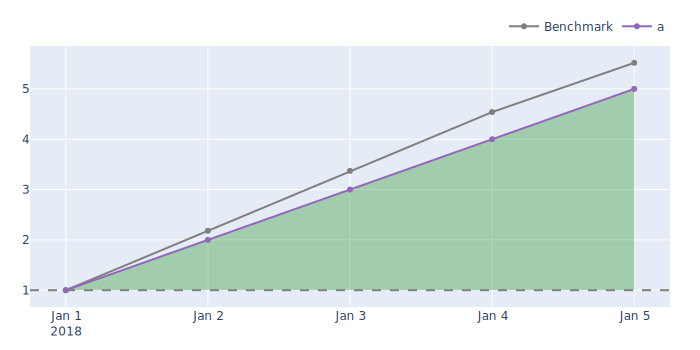

In [10]:
returns['a'].vbt.returns.plot_cum_returns(benchmark_rets).show_svg()

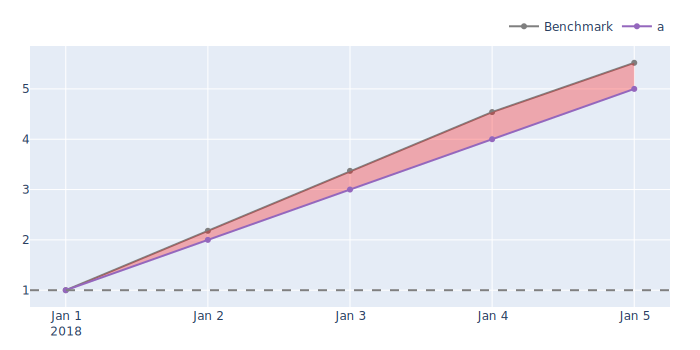

In [11]:
returns['a'].vbt.returns.plot_cum_returns(benchmark_rets, fill_to_benchmark=True).show_svg()